In [34]:
import torch
import torchvision
from torchvision import transforms, datasets

import math

In [5]:
train = datasets.MNIST("", download = True ,transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", download = True ,transform = transforms.Compose([transforms.ToTensor()]), train = False)

In [6]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, 
                                       shuffle=True)

#bigger datasets, bs matters much more

testset = torch.utils.data.DataLoader(test, batch_size=10, 
                                       shuffle=True)
            #need to be general so NN doesn't overfit to a single num

In [16]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [22]:
x, y = data[0][0], data[1][0]


In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
print(data[0][0].shape)

#pytorch has a 1 there! need to know your shape

torch.Size([1, 28, 28])


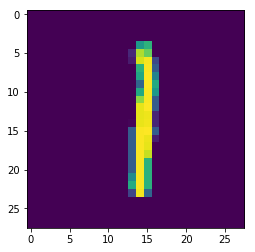

In [25]:
plt.imshow(data[0][0].view([28,28]))

In [26]:
#balancing data? 

#could change class weights, or just make more balanced data

In [27]:
total = 0 
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1

print(counter_dict)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [28]:
import torch.nn as nn
import torch.functional as F

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() #initializes nn.Module, see text based version for clarification
        
        self.fc1 = nn.Linear(28*28, 64) #flattened img, 3 layers of 64 connected neurons
        self.fc2 = nn.Linear(64, 64) #flattened img, 3 layers of 64 connected neurons
        self.fc3 = nn.Linear(64, 64) #flattened img, 3 layers of 64 connected neurons
        self.fc4 = nn.Linear(64, 10) #flattened img, 3 layers of 64 connected neurons
        
        
    def forward(self, x): #how data will flow through network
        x = nn.functional.relu(self.fc1(x))
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        
        return torch.nn.functional.log_softmax(x, dim = 1)
    

    
net = Net()
print(net)

    

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


AttributeError: cannot assign module before Module.__init__() call

means that you haven't called super().__init__()

In [13]:
X = torch.rand((28,28))
X = X.view(1, 28*28) #need the 1 in front!

In [14]:
net(X)

tensor([[-2.2590, -2.3479, -2.3202, -2.2663, -2.3625, -2.3430, -2.1739, -2.3599,
         -2.3595, -2.2523]], grad_fn=<LogSoftmaxBackward>)

In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

In [18]:
#this is CosineAnnealingLR, no modifications

class the_reference(optim.lr_scheduler.CosineAnnealingLR):
    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]
    

Vanilla NN, SGD / CosineAnnealing 

In [27]:
#vanilla
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_ = 0.01

optimizer = torch.optim.SGD(net.parameters(), lr = lr_)

scheduler = CosineAnnealingLR(optimizer, T_max=lr_ )

epochs = 12

for epoch in range(epochs):
    for data in trainset:
        #data is a batch of features, labels
        X,y = data
        
        optimizer.step()
        
        scheduler.step() #alter learning rate
        
        net.zero_grad() #reset gradient at each iteration
        
        output = net(X.view(-1, 28*28))
        
        loss = nn.functional.nll_loss(output, y) # output is scalar, using nll
        #if onehot, you can use MSE 
        
        loss.backward() #back proprogates gradients
        #can just iterate over net.parameters 
        
        
    print(loss)
        
        
        
        

tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.2749, grad_fn=<NllLossBackward>)
tensor(0.0029, grad_fn=<NllLossBackward>)
tensor(9.7998e-05, grad_fn=<NllLossBackward>)
tensor(0.0002, grad_fn=<NllLossBackward>)
tensor(0.0310, grad_fn=<NllLossBackward>)
tensor(0.0020, grad_fn=<NllLossBackward>)
tensor(0.0024, grad_fn=<NllLossBackward>)
tensor(0.0004, grad_fn=<NllLossBackward>)
tensor(0.0081, grad_fn=<NllLossBackward>)
tensor(3.7212e-05, grad_fn=<NllLossBackward>)
tensor(0.0001, grad_fn=<NllLossBackward>)


This is the modified SGD Optimizer I came up with - note the tot_epochs, lr_decay_factor, and per_epochs arguements

In [43]:
required = 0.001

class mod_SGD(torch.optim.SGD):

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, per_epochs = 3, tot_epochs = 12, lr_decay_factor = .2):
        #added decay factor, total epoch, and per epochs clauses
        self.per_epochs = per_epochs
        self.tot_epochs = tot_epochs 
        self.lr_decay_factor = lr_decay_factor
        
        
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(torch.optim.SGD, self).__init__(params, defaults)
      

    def __setstate__(self, state):
        super(torch.optim.SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        epoch_period = 0 #counter to use in the decay factor for warm restarts
        
        if self.tot_epochs % self.per_epochs == 0:
            epoch_period += 1
             
    
        
        loss = None
        if closure is not None:
            if self.tot_epochs % self.per_epochs == 0:
                #added this line here to reset the initial learning rate
                    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['initial_lr'] * math.exp(-(lr_decay_factor*self.epoch_period))
                    

            else:
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                    

                p.data.add_(-group['lr'], d_p)

        return loss

In [44]:
import math
#vanilla
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_ = 0.01

optimizer = mod_SGD(net.parameters(), lr = lr_)

scheduler = CosineAnnealingLR(optimizer, T_max=lr_)



NN With Modified SGD, Standard Cosine Annealing


notes: Looking through, I haven't implemented a 'minimum learning rate' parameter as specified in the paper - perhaps this is why the error bounces around so much? I would have though the model would get closer and closer, not have a huge jump in loss (from .0050 to .2554), as shown below. 

In [45]:
lr_ = 0.01


for epoch in range(optimizer.tot_epochs):
    for data in trainset:
        #data is a batch of features, labels
        X,y = data
        
        
        #if epoch is equal to per_epoch, then set the lr_ back to the default(?) lr
        
        optimizer.step()
        
        scheduler.step() #alter learning rate
        
        net.zero_grad() #reset gradient at each iteration
        
        output = net(X.view(-1, 28*28))
        
        loss = nn.functional.nll_loss(output, y) # output is scalar, using nll
        #if onehot, you can use MSE 
        
        loss.backward() #back proprogates gradients
        #can just iterate over net.parameters 
        
        
    print(loss)
        
        
        
        
        

tensor(0.0077, grad_fn=<NllLossBackward>)
tensor(0.0011, grad_fn=<NllLossBackward>)
tensor(0.0007, grad_fn=<NllLossBackward>)
tensor(8.6278e-05, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0047, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(1.9073e-07, grad_fn=<NllLossBackward>)
tensor(3.6591e-05, grad_fn=<NllLossBackward>)
tensor(0.0038, grad_fn=<NllLossBackward>)
tensor(6.9868e-05, grad_fn=<NllLossBackward>)
tensor(2.1896e-05, grad_fn=<NllLossBackward>)


Your modifed SGD and COSINE W WARM RESTARTS

In [50]:
optimizer = mod_SGD(net.parameters(), lr = lr_)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 3)

In [51]:
for epoch in range(12):
    for data in trainset:
        #data is a batch of features, labels
        X,y = data
        
        
        #if epoch is equal to per_epoch, then set the lr_ back to the default(?) lr
        
        optimizer.step()
        
        scheduler.step() #alter learning rate
        
        net.zero_grad() #reset gradient at each iteration
        
        output = net(X.view(-1, 28*28))
        
        loss = nn.functional.nll_loss(output, y) # output is scalar, using nll
        #if onehot, you can use MSE 
        
        loss.backward() #back proprogates gradients
        #can just iterate over net.parameters 
        
        
    print(loss)
        
        

tensor(0.0005, grad_fn=<NllLossBackward>)
tensor(0.0015, grad_fn=<NllLossBackward>)
tensor(1.0418e-05, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward>)
tensor(0.0171, grad_fn=<NllLossBackward>)
tensor(0.0020, grad_fn=<NllLossBackward>)
tensor(0.0006, grad_fn=<NllLossBackward>)
tensor(0.0016, grad_fn=<NllLossBackward>)
tensor(0.0017, grad_fn=<NllLossBackward>)
tensor(0.0003, grad_fn=<NllLossBackward>)
tensor(1.2540e-05, grad_fn=<NllLossBackward>)
tensor(0.0007, grad_fn=<NllLossBackward>)


In [61]:
optimizer = torch.optim.SGD(net.parameters(), lr = lr_)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 3)

PYTORCH SGDR BASELINE

In [54]:
for epoch in range(12):
    for data in trainset:
        #data is a batch of features, labels
        X,y = data
        
        #if epoch is equal to per_epoch, then set the lr_ back to the default(?) lr
        
        optimizer.step()
        
        net.zero_grad() #reset gradient at each iteration
        
        output = net(X.view(-1, 28*28))
        
        loss = nn.functional.nll_loss(output, y) # output is scalar, using nll
        #if onehot, you can use MSE 
        
        loss.backward() #back proprogates gradients
        #can just iterate over net.parameters 
        
        
    print(loss)
        

tensor(1.9359e-05, grad_fn=<NllLossBackward>)
tensor(4.2383e-05, grad_fn=<NllLossBackward>)
tensor(1.4543e-05, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0017, grad_fn=<NllLossBackward>)
tensor(2.2888e-06, grad_fn=<NllLossBackward>)
tensor(0.0001, grad_fn=<NllLossBackward>)
tensor(5.2452e-07, grad_fn=<NllLossBackward>)
tensor(1.1730e-05, grad_fn=<NllLossBackward>)
tensor(0.0002, grad_fn=<NllLossBackward>)
tensor(0.0033, grad_fn=<NllLossBackward>)
tensor(0.0001, grad_fn=<NllLossBackward>)


Clearly, the CosineWithWarmRestarts is superior to my hodgepodge implementation. You can see that it immediately hits a low loss. We can see the loss come back up slightly, but that's more due to the small size of the dataset - model already hitting an the limitations of the data!

I'm curious to see how the Pytorch team managed to implement it into the lr_scheduler, as I found it easier to implement it into SGD (probably not a good decision on my part). 

Below this is my attempt at modifiying CosineAnnealingWarmRes, but decided to keep my modification to SGD as shown above

In [35]:
class mod_CosineAnnealingWarmRes(torch.optim.lr_scheduler.CosineAnnealingLR):

    def __init__(self, optimizer, T_max, T_O, T_i, eta_min=0, last_epoch=-1, btwn_restarts = 3):
            self.T_max = T_max
            self.eta_min = eta_min
            self.T_O = T_O
            self.T_i = T_i
            self.last_epoch = last_epoch
            self.btwn_restarts = btwn_restarts
            super(torch.optim.lr_scheduler.CosineAnnealingLR, self).__init__(optimizer, last_epoch)
            

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]
    
    def step(self, epoch = None):
        
        if epoch is None:
            epoch = self.last_epoch + 1
            t_curr = 1 
        else:
            if epoch > self.T_O:
                self.T_i = epoch % self.T_O
            else:
                self.T_i = self.T_O
                t_curr = epoch 
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
            
            
        
    
    

In [36]:
lr_ = 0.01



optimizer = torch.optim.SGD(net.parameters(), lr = lr_)

scheduler = mod_CosineAnnealingWarmRes(optimizer, T_max = 3, T_i=3, T_O=3)

In [37]:
for epoch in range(12):
    for data in trainset:
        #data is a batch of features, labels
        X,y = data
        
        
        #if epoch is equal to per_epoch, then set the lr_ back to the default(?) lr
        
        optimizer.step()
        
        scheduler.step() #alter learning rate
        
        net.zero_grad() #reset gradient at each iteration
        
        output = net(X.view(-1, 28*28))
        
        loss = nn.functional.nll_loss(output, y) # output is scalar, using nll
        #if onehot, you can use MSE 
        
        loss.backward() #back proprogates gradients
        #can just iterate over net.parameters 
        
        
    print(loss)

tensor(0.1765, grad_fn=<NllLossBackward>)
tensor(0.0809, grad_fn=<NllLossBackward>)
tensor(0.1460, grad_fn=<NllLossBackward>)
tensor(0.0038, grad_fn=<NllLossBackward>)
tensor(0.1771, grad_fn=<NllLossBackward>)
tensor(0.0638, grad_fn=<NllLossBackward>)
tensor(0.1845, grad_fn=<NllLossBackward>)
tensor(0.0326, grad_fn=<NllLossBackward>)
tensor(0.1637, grad_fn=<NllLossBackward>)
tensor(0.0078, grad_fn=<NllLossBackward>)
tensor(0.0025, grad_fn=<NllLossBackward>)
tensor(0.0015, grad_fn=<NllLossBackward>)
